# Data Preparation

In [1]:
# Here are all the imports needed for this phase

# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting and normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('float_format', '{:f}'.format)
pd.set_option('max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
fraud_merged_df = pd.read_csv("fraud_merged_data.csv")

In [3]:
fraud_merged_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,Unknown
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,Unknown
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,Unknown
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,Unknown
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,Unknown


## Data aggregation

As we said in the previous phase (cf file "Data Understanding part 2"), a large number of countries have few transactions.

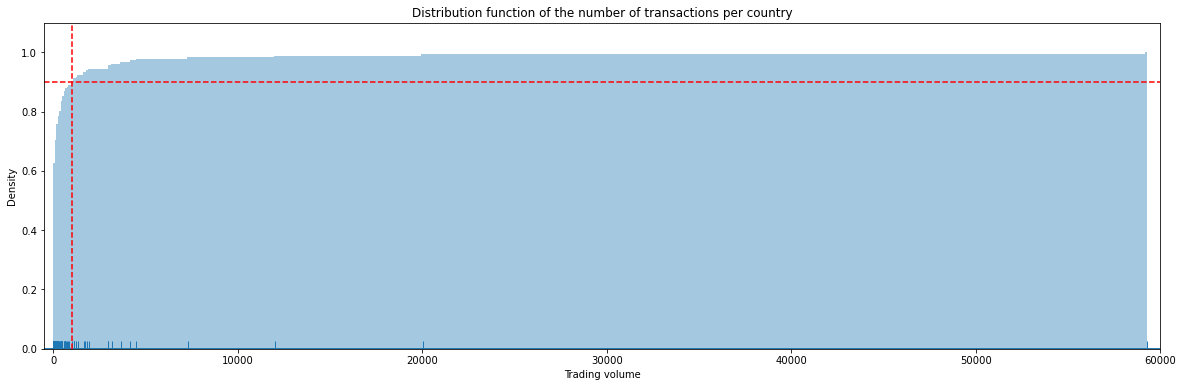

In [4]:
plt.figure(figsize=(20,6))

sns.distplot(
    fraud_merged_df["country"].value_counts(),
    bins='auto',
    rug=True,
    hist_kws={'cumulative': True}
)
plt.xlim([-500, 60000])
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axvline(x=1000, color='r', linestyle='--')
plt.xlabel("Trading volume")
plt.title("Distribution function of the number of transactions per country")

plt.show()

* In our data sample, for a threshold value of 1000 transactions, we find almost 90% of countries.
* So, we will create a modality named "Other" in which all countries with fewer than 1000 transactions will be included. 

In [5]:
countries_low_trading_volume = fraud_merged_df["country"].value_counts()[fraud_merged_df["country"].value_counts() <= 1000].index
fraud_merged_df.loc[fraud_merged_df["country"].isin(countries_low_trading_volume), "country"] = 'Other'

In [6]:
country_count = pd.DataFrame(fraud_merged_df["country"].value_counts())
country_count_per_class = fraud_merged_df.groupby(["country", "class"])["ip_address"].count().reset_index().rename(columns={"ip_address" : "count"})
country_count_per_class = country_count_per_class.sort_values(by=["count"], ascending=False)

In [7]:
country_count.head()

,country
United States,59283
Unknown,20017
Other,16969
China,12039
Japan,7306


In [8]:
country_count_per_class.head(10)

,country,class,count
38,United States,0,53578
40,Unknown,0,18346
24,Other,0,15260
6,China,0,10995
16,Japan,0,6591
39,United States,1,5705
36,United Kingdom,0,4013
18,Korea Republic of,0,3782
10,Germany,0,3386
8,France,0,2864


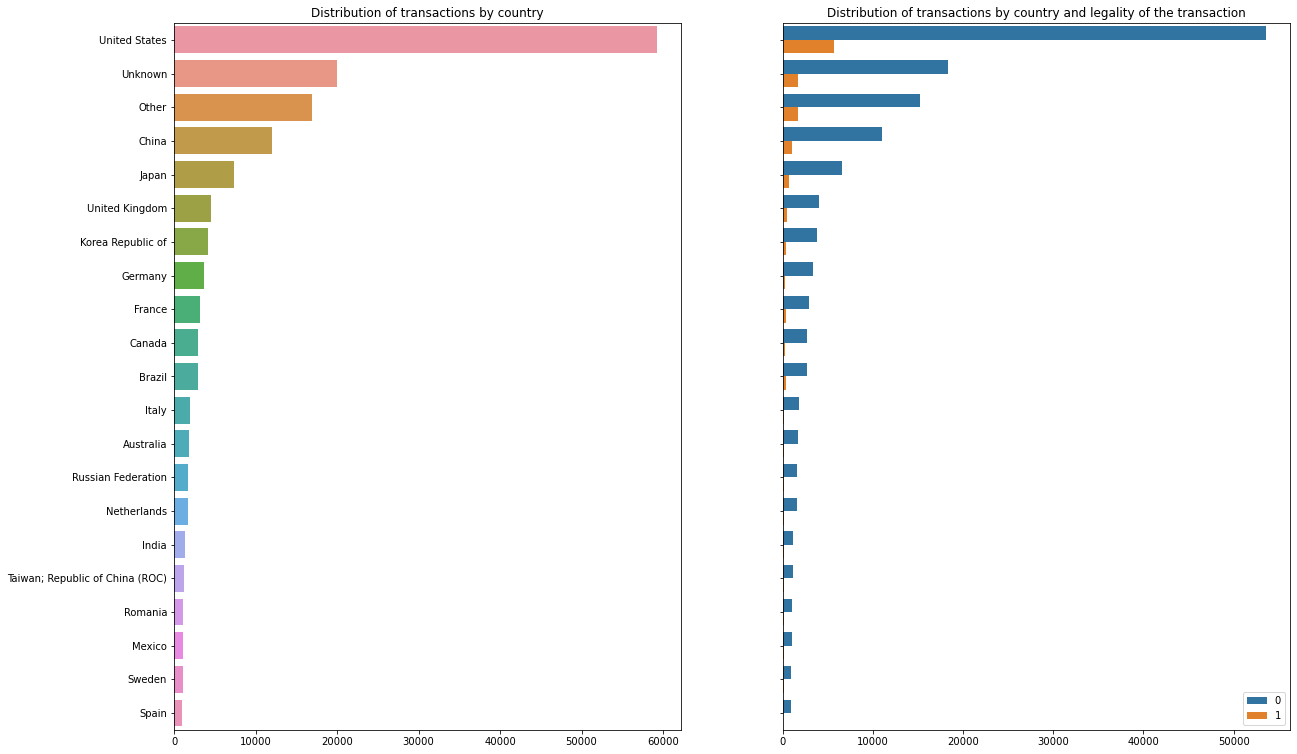

In [9]:
plt.figure(figsize=(20,13))

plt.subplot(121)
sns.barplot(data=country_count, y=country_count.index, x="country")
plt.title("Distribution of transactions by country")
plt.xlabel('')

plt.subplot(122)
ax = sns.barplot(data=country_count_per_class, y="country", x="count", hue="class")
plt.title("Distribution of transactions by country and legality of the transaction")
plt.legend(loc='lower right')
plt.xlabel('')
plt.ylabel('')
ax.set_yticklabels([])

plt.show()

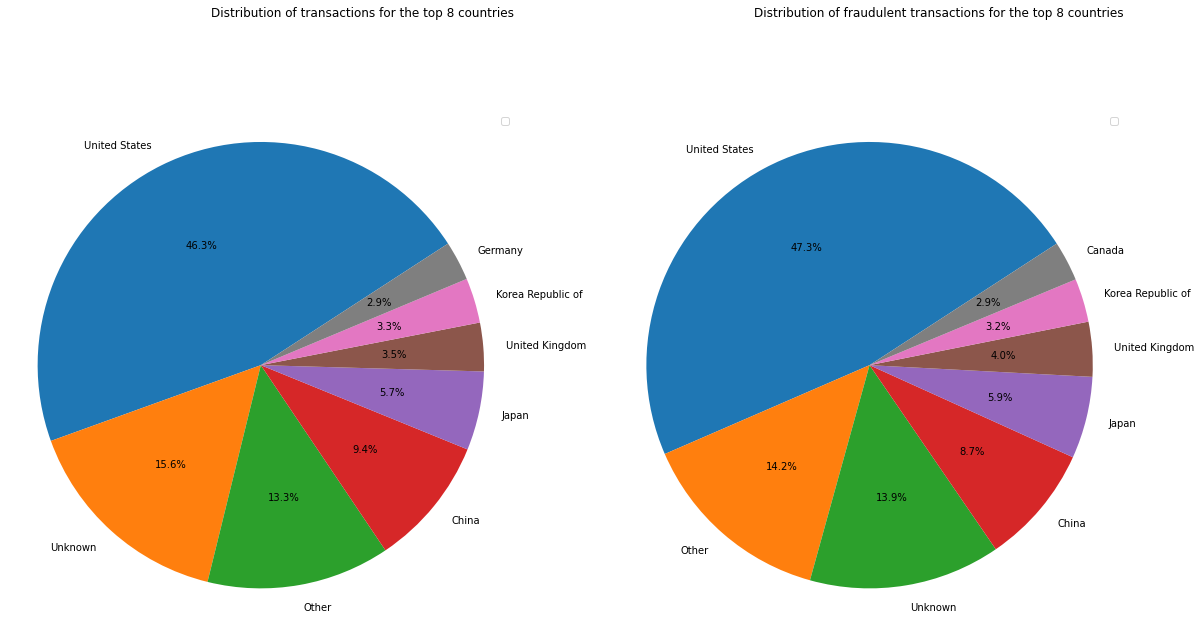

In [10]:
plt.figure(figsize=(20,13))

plt.subplot(121)
plt.pie(country_count[["country"]].head(8), 
        labels=country_count[["country"]].head(8).index, 
        autopct='%1.1f%%', 
        radius=1.1,
       startangle=33)
plt.legend('')
plt.title("Distribution of transactions for the top 8 countries", loc='right', pad=95)

plt.subplot(122)
plt.pie(country_count_per_class.loc[country_count_per_class["class"] == 1, "count"].head(8), 
        labels=country_count_per_class.loc[country_count_per_class["class"] == 1,"country"].head(8), 
        autopct='%1.1f%%', 
        radius=1.1,
       startangle=33)
plt.legend('')
plt.title("Distribution of fraudulent transactions for the top 8 countries", loc='right', pad=95)

plt.show()

* More than 40% of the transactions come from the United States. This proportion is also found in all fraudulent transactions.
* The Unknown class of the country variable is the second most frequent modality in our sample. In other words, the transactions corresponding to ip addresses whose origin we were unable to identify are numerous. However, this does not make them suspicious : the proportion of fraudulent transactions belonging to this group is equivalent.

## Feature engineering
### Creating variables
<!--## Feature engineering
### Combining several variables into one
### Grouping-->

We noticed in Data Understanding phase that a little bit more than 50% of fraudulent transactions happened 1 second after the user's account was created. Then, it is quite normal to create a variable related to this finding.

In [11]:
fraud_merged_df["signup_time"] = pd.to_datetime(fraud_merged_df["signup_time"])
fraud_merged_df["purchase_time"] = pd.to_datetime(fraud_merged_df["purchase_time"])

In [12]:
fraud_merged_df["seconds_between_purchase_signup"] = fraud_merged_df[["signup_time", "purchase_time"]].apply(
                                                        lambda x : (x[1]-x[0]).total_seconds(), 
                                                        axis=1
                                                )

It may be useful to create other variables related to the time of purchase.

In [13]:
fraud_merged_df["purchase_hour"] = fraud_merged_df["purchase_time"].apply(lambda x : x.hour)
fraud_merged_df["purchase_day_of_week"] = fraud_merged_df["purchase_time"].apply(lambda x : x.strftime('%A'))

In [14]:
fraud_merged_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,seconds_between_purchase_signup,purchase_hour,purchase_day_of_week
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,Unknown,1763014.000000,10,Sunday
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,Unknown,1084823.000000,17,Friday
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,Unknown,749320.000000,8,Tuesday
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,Unknown,7434634.000000,21,Thursday
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,Unknown,1407619.000000,7,Sunday


## Data limitation
### Deleting variables
<!-- ## Data limitation
### Deleting records/samples/individuals-->

* We no longer need the variables __signup_time__, __purchase_time__ and __ip_address__ (used to make the join).
* __user_id__ and __device_id__ are identifiers : they provide no relevant information.

In [15]:
fraud_merged_df = fraud_merged_df.drop(["signup_time", "purchase_time", "ip_address", "user_id", "device_id"], axis=1)

In [16]:
fraud_merged_df.head()

,purchase_value,source,browser,sex,age,class,country,seconds_between_purchase_signup,purchase_hour,purchase_day_of_week
0,46,Direct,Safari,M,36,0,Unknown,1763014.000000,10,Sunday
1,33,Ads,IE,F,30,0,Unknown,1084823.000000,17,Friday
2,33,Direct,FireFox,F,32,0,Unknown,749320.000000,8,Tuesday
3,33,Ads,IE,M,40,0,Unknown,7434634.000000,21,Thursday
4,55,Ads,Safari,M,38,0,Unknown,1407619.000000,7,Sunday


## Dummyfication

The categorical variables __source__, __browser__, __sex__, __country__, __purchase_day_of_week__ are dummyfied.

In [17]:
fraud_merged_dummyfied_df = pd.get_dummies(fraud_merged_df, drop_first=True)

In [18]:
fraud_merged_dummyfied_df.head()

,purchase_value,age,class,seconds_between_purchase_signup,purchase_hour,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Korea Republic of,country_Mexico,country_Netherlands,country_Other,country_Romania,country_Russian Federation,country_Spain,country_Sweden,country_Taiwan; Republic of China (ROC),country_United Kingdom,country_United States,country_Unknown,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday
0,46,36,0,1763014.000000,10,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,33,30,0,1084823.000000,17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,33,32,0,749320.000000,8,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,33,40,0,7434634.000000,21,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,55,38,0,1407619.000000,7,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


## Partition

We separate the target variable from the other variables.

In [19]:
X = fraud_merged_dummyfied_df.drop("class", axis=1)
y = fraud_merged_dummyfied_df["class"]

We separate our data into training set and test set.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [21]:
X_train.shape, y_train.size, X_test.shape, y_test.size

((120889, 37), 120889, (30223, 37), 30223)

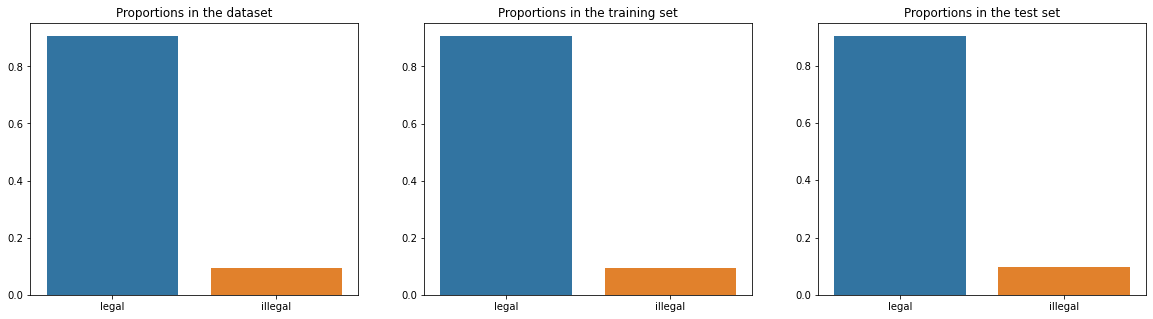

In [22]:
plt.figure(figsize=(20,5))

plt.subplot(131)
sns.barplot(y=y.value_counts(normalize=True), x=["legal", "illegal"])
plt.title("Proportions in the dataset")
plt.ylabel('')

plt.subplot(132)
sns.barplot(y=y_train.value_counts(normalize=True), x=["legal", "illegal"])
plt.title("Proportions in the training set")
plt.ylabel('')

plt.subplot(133)
sns.barplot(y=y_test.value_counts(normalize=True), x=["legal", "illegal"])
plt.title("Proportions in the test set")
plt.ylabel('')

plt.show()

## Standardization

We normalize the numerical features.

In [23]:
numerical_features=[]

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)

In [24]:
numerical_features

['purchase_value', 'age', 'seconds_between_purchase_signup', 'purchase_hour']

In [25]:
fraud_scaler = StandardScaler()
features_train_scaled = fraud_scaler.fit_transform(X_train.loc[:, numerical_features])

In [26]:
for ind, col in enumerate(numerical_features):
    X_train[col] = features_train_scaled[:,ind]

In [27]:
X_train.head()

,purchase_value,age,seconds_between_purchase_signup,purchase_hour,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Korea Republic of,country_Mexico,country_Netherlands,country_Other,country_Romania,country_Russian Federation,country_Spain,country_Sweden,country_Taiwan; Republic of China (ROC),country_United Kingdom,country_United States,country_Unknown,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday
119187,0.712890,-0.017282,-1.138580,-0.653497,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
133622,0.549086,0.678751,1.302103,-1.087733,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
103404,-1.198160,0.910763,-1.330176,-0.653497,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
55079,0.549086,-0.133288,0.171997,0.504464,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
98816,-1.361965,1.258780,-0.339607,-0.364007,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [28]:
features_test_scaled = fraud_scaler.transform(X_test.loc[:, numerical_features])
for ind, col in enumerate(numerical_features):
    X_test[col] = features_test_scaled[:,ind]

In [29]:
X_test.head()

,purchase_value,age,seconds_between_purchase_signup,purchase_hour,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Korea Republic of,country_Mexico,country_Netherlands,country_Other,country_Romania,country_Russian Federation,country_Spain,country_Sweden,country_Taiwan; Republic of China (ROC),country_United Kingdom,country_United States,country_Unknown,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday
92865,-1.471167,-1.061333,0.636618,1.083445,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
50746,0.603687,-1.293344,-0.284421,-1.232478,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
128421,-0.051530,0.794757,-1.457744,-1.232478,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
146243,-0.597544,0.910763,0.191498,-0.074516,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
44524,0.931296,-0.829322,1.565287,0.359719,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


## Next step : Modeling

We need to export the data for the further process.

In [30]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)